In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import io
from helper import *

from sklearn.model_selection import GridSearchCV

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import mlflow
import mlflow.pytorch

In [5]:
from torch.utils.tensorboard import SummaryWriter
import torchvision.utils as vutils

In [ ]:
# End any active MLflow run before starting a new one
if mlflow.active_run() is not None:
    mlflow.end_run()
mlflow.set_experiment("Clasificador_Imagenes")

<Experiment: artifact_location='file:///c:/Users/Lenovo/Valen/ITBA/20251Q/Redes/skin-dataset-clasification/mlruns/690872340522489431', creation_time=1750042881013, experiment_id='690872340522489431', last_update_time=1750042881013, lifecycle_stage='active', name='Clasificador_Imagenes', tags={}>

In [7]:
def log_classification_report(model, loader, writer, device, classes, step, prefix="val"):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    fig_cm, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
    ax.set_title(f'{prefix.title()} - Confusion Matrix')

    # Guardar localmente y subir a MLflow
    fig_path = f"confusion_matrix_{prefix}_epoch_{step}.png"
    fig_cm.savefig(fig_path)
    mlflow.log_artifact(fig_path)
    os.remove(fig_path)

    plot_to_tensorboard(fig_cm, writer, f"{prefix}/confusion_matrix", step)

    cls_report = classification_report(all_labels, all_preds, target_names=classes)
    writer.add_text(f"{prefix}/classification_report", f"<pre>{cls_report}</pre>", step)

    # También loguear texto del reporte
    with open(f"classification_report_{prefix}_epoch_{step}.txt", "w") as f:
        f.write(cls_report)
    mlflow.log_artifact(f.name)
    os.remove(f.name)


In [8]:
# Entrenamiento y validación
def evaluate(model, loader, writer, device, classes, epoch=None, prefix="val"):
    log_classification_report(model, loader, writer, device, classes, step=epoch , prefix="val")
    model.eval()
    correct, total, loss_sum = 0, 0, 0.0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for i, (images, labels) in enumerate(loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            loss_sum += loss.item()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Loguear imágenes del primer batch
            if i == 0 and epoch is not None:
                img_grid = vutils.make_grid(images[:8].cpu(), normalize=True)
                writer.add_image(f"{prefix}/images", img_grid, global_step=epoch)

    acc = 100.0 * correct / total
    avg_loss = loss_sum / len(loader)

    if epoch is not None:
        writer.add_scalar(f"{prefix}/loss", avg_loss, epoch)
        writer.add_scalar(f"{prefix}/accuracy", acc, epoch)

    return avg_loss, acc

In [ ]:
# Paths
train_dir = "../../data/Split_smol/train"
val_dir = "../../data/Split_smol/val/"

In [10]:
# Crear directorio de logs de tensorboard
log_dir = "runs/experimento_skin"
writer = SummaryWriter(log_dir=log_dir)

In [11]:
np.random.rand()

0.4131382120759326

In [12]:
hparams_space= {
    "model": ("CNNClassifier"),
    "input_size":  [32,64,128],
    "batch_size": [16,64,128],
    "lr": [1e-2,1e-3,1e-4],
    "epochs": 200,
    "optimizer":  ["Adam", "SGD"],
    "HFlip": [0.0,0.5],
    "VFlip": [0.0,0.5],
    "RBContrast": [0.0, 0.5],
    "loss_fn": "CrossEntropyLoss",
    "train_dir": train_dir,
    "val_dir": val_dir,
    "es_patience": 5,
    "dropout": [0.0, 0.1,0.2,0.3],
}

PermissionError: [WinError 5] Acceso denegado: 'C:\\Users\\Lenovo'

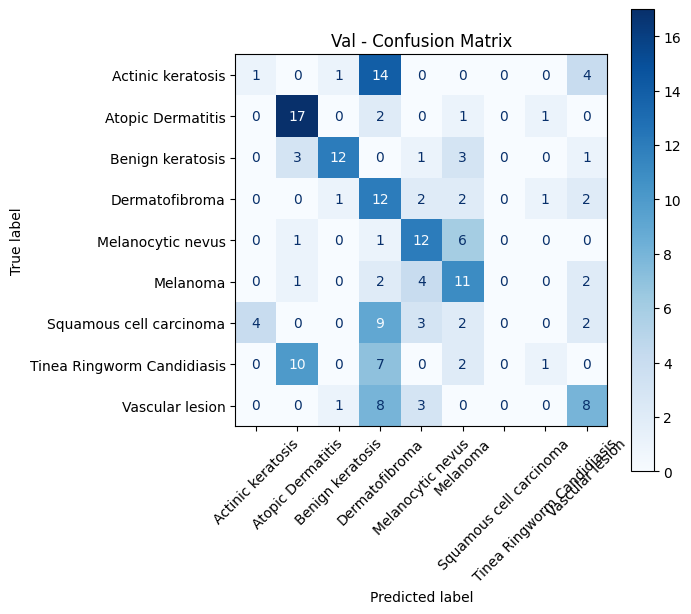

In [ ]:
modelnbr = 0
for input_size in hparams_space["input_size"]:
    for batch_size in hparams_space["batch_size"]:
        for lr in hparams_space["lr"]:
            for optimizer in hparams_space["optimizer"]:
                for HFlip in hparams_space["HFlip"]:
                    for VFlip in hparams_space["VFlip"]:
                        for RBContrast in hparams_space["RBContrast"]:
                            for dropout in hparams_space["dropout"]:
                                if np.random.rand() < 0.05:
                                    print(f"modelo número: {modelnbr}", end = "\r")
                                    modelnbr += 1
                                    hparams= {
                                        "model": ("CNNClassifier"),
                                        "input_size":  input_size,
                                        "batch_size": batch_size,
                                        "lr": lr,
                                        "epochs": 200,
                                        "optimizer": optimizer,
                                        "HFlip": HFlip,
                                        "VFlip": VFlip,
                                        "RBContrast": RBContrast,
                                        "loss_fn": "CrossEntropyLoss",
                                        "train_dir": train_dir,
                                        "val_dir": val_dir,
                                        "es_patience": 5,
                                        "dropout": dropout,
                                    }
                                    train_transform = A.Compose([
                                        A.Resize(hparams["input_size"], hparams["input_size"]),
                                        A.HorizontalFlip(p=hparams["HFlip"]),
                                        A.VerticalFlip(p=hparams["VFlip"]),
                                        A.RandomBrightnessContrast(p=hparams["RBContrast"]),
                                        A.Normalize(),
                                        ToTensorV2()
                                    ])
                                    val_test_transform = A.Compose([
                                        A.Resize(hparams["input_size"], hparams["input_size"]),
                                        A.Normalize(),
                                        ToTensorV2()
                                    ])
                                    train_dataset = CustomImageDataset(train_dir, transform=train_transform)
                                    val_dataset   = CustomImageDataset(val_dir, transform=val_test_transform)
                                    batch_size = hparams["batch_size"]
                                    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
                                    val_loader   = DataLoader(val_dataset, batch_size=batch_size)
                                    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
                                    num_classes = len(set(train_dataset.labels))
                                    model = CNNClassifier(num_classes=num_classes, input_size = hparams["input_size"], dropout = hparams["dropout"]).to(device)
                                    criterion = nn.CrossEntropyLoss()
                                    optimizer = optim.Adam(model.parameters(), lr=hparams["lr"]) if hparams["optimizer"]=="Adam" else optim.SGD(model.parameters(), lr=hparams["lr"])
                                    hparams["count_params"] = count_parameters(model)
                                    with mlflow.start_run():
                                        # Log hiperparámetros
                                        mlflow.log_params(hparams)
                                        best_val_acc = 0
                                        best_val_loss = 0
                                        best_train_acc = 0
                                        best_train_loss = 0
                                        best_epoch = 0
                                        for epoch in range(hparams["epochs"]):
                                            model.train()
                                            running_loss = 0.0
                                            correct, total = 0, 0
                                        
                                            for images, labels in train_loader:
                                                images, labels = images.to(device), labels.to(device)
                                        
                                                optimizer.zero_grad()
                                                outputs = model(images)
                                                loss = criterion(outputs, labels)
                                                loss.backward()
                                                optimizer.step()
                                        
                                                running_loss += loss.item()
                                                _, preds = torch.max(outputs, 1)
                                                correct += (preds == labels).sum().item()
                                                total += labels.size(0)
                                        
                                            train_loss = running_loss / len(train_loader)
                                            train_acc = 100.0 * correct / total
                                            val_loss, val_acc = evaluate(model, val_loader, writer, device,train_dataset.label_encoder.classes_,epoch=epoch, prefix="val")
                                        
                                            #print(f"Epoch {epoch+1}:")
                                            #print(f"  Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%")
                                            #print(f"  Val   Loss: {val_loss:.4f}, Accuracy: {val_acc:.2f}%")
                                        
                                            writer.add_scalar("train/loss", train_loss, epoch)
                                            writer.add_scalar("train/accuracy", train_acc, epoch)
                                        
                                            # Log en MLflow
                                            mlflow.log_metrics({
                                                "train_loss": train_loss,
                                                "train_accuracy": train_acc,
                                                "val_loss": val_loss,
                                                "val_accuracy": val_acc
                                            }, step=epoch)
                                            if val_acc > best_val_acc:
                                                best_val_acc = val_acc
                                                best_val_loss = val_loss
                                                best_train_acc = train_acc
                                                best_train_loss = train_loss
                                                best_epoch = epoch
                                                # Guardar modelo
                                                torch.save(model.state_dict(), "mlp_model.pth")
                                                #print("Modelo guardado como 'mlp_model.pth'")
                                                mlflow.log_artifact("mlp_model.pth")
                                                mlflow.pytorch.log_model(model, artifact_path="pytorch_model")
                                            elif epoch > best_epoch + hparams["es_patience"]:
                                                #print("Early Stopping")
                                                break
                                                
                                        mlflow.log_metrics({
                                                "train_loss": best_train_loss,
                                                "train_accuracy": best_train_acc,
                                                "val_loss": best_val_loss,
                                                "val_accuracy": best_val_acc,
                                                "best_epoch": best_epoch
                                            }, step=epoch+1)